In [99]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import random
import os
os.environ['R_HOME'] = 'C:\Programming\R\R-4.4.2'

In [100]:
# 재현성 난수 고정
SEED = 100

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [101]:
# data load
df_name = 'freesolv'
df = pd.read_csv('C:\Programming\Github\EGCN\data\\' + df_name + '.csv')

smiles_list = df['smiles'].tolist()

# target 정의
target = df.iloc[:,-1]

print(smiles_list[:5])
print(target[:5])

['CN(C)C(=O)c1ccc(cc1)OC', 'CS(=O)(=O)Cl', 'CC(C)C=C', 'CCc1cnccn1', 'CCCCCCCO']
0   -11.01
1    -4.87
2     1.83
3    -5.45
4    -4.21
Name: freesolv, dtype: float64


In [102]:
# 분자 특성 추출 class
class MolecularFeatureExtractor:
    def __init__(self):
        self.descriptors = [desc[0] for desc in Descriptors._descList]

    def extract_molecular_features(self, smiles_list):
        features_dict = {desc: [] for desc in self.descriptors}

        for smiles in smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                for descriptor_name in self.descriptors:
                    descriptor_function = getattr(Descriptors, descriptor_name)
                    try:
                        features_dict[descriptor_name].append(descriptor_function(mol))
                    except:
                        features_dict[descriptor_name].append(None)
            else:
                for descriptor_name in self.descriptors:
                    features_dict[descriptor_name].append(None)

        return pd.DataFrame(features_dict)

In [103]:
# 분자 특성 추출 및 데이터프레임 정의
extractor = MolecularFeatureExtractor()
df_all_features = extractor.extract_molecular_features(smiles_list)

df_all_features['target'] = target
df_all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,11.429183,0.002457,11.429183,0.002457,0.686360,179.219,166.115,179.094629,70,0,...,0,0,0,0,0,0,0,0,0,-11.01
1,9.397377,-3.194444,9.397377,0.925154,0.421427,114.553,111.529,113.954228,32,0,...,0,0,0,0,0,0,0,0,0,-4.87
2,3.560185,0.648148,3.560185,0.648148,0.412737,70.135,60.055,70.078250,30,0,...,0,0,0,0,0,0,0,0,0,1.83
3,4.034722,0.966111,4.034722,0.966111,0.536795,108.144,100.080,108.068748,42,0,...,0,0,0,0,0,0,0,0,0,-5.45
4,8.365587,0.364796,8.365587,0.364796,0.544191,116.204,100.076,116.120115,50,0,...,0,0,0,0,0,0,0,3,0,-4.21


# t-sne

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## 사분위수

In [105]:
Q1 = np.percentile(target, 25)
Q2 = np.percentile(target, 50)
Q3 = np.percentile(target, 75)

idx_Q1 = np.where(target < Q1)[0]
idx_Q2 = np.where((target >= Q1) & (target < Q2))[0]
idx_Q3 = np.where((target >= Q2) & (target < Q3))[0]
idx_Q4 = np.where(target >= Q3)[0]

print(Q1, Q2, Q3)
print(idx_Q1, idx_Q2, idx_Q3, idx_Q4)

-5.7275 -3.5300000000000002 -1.2149999999999999
[  0   5  18  20  21  29  32  33  35  40  42  44  52  53  56  58  63  66
  69  71  72  74  79  82  83  89  91  98  99 113 117 118 121 124 128 151
 152 154 157 161 163 171 178 190 191 197 198 201 209 210 212 213 215 227
 237 238 243 246 247 254 266 267 276 279 280 283 293 297 308 309 311 323
 324 325 328 333 334 336 344 349 357 362 364 375 377 384 387 389 390 391
 394 397 398 404 405 406 409 413 414 416 421 422 423 428 436 440 441 443
 444 449 460 462 464 465 467 469 470 472 476 478 479 481 485 492 512 513
 515 516 522 523 537 538 541 543 545 547 549 555 557 558 561 571 575 576
 577 578 582 589 602 603 604 609 612 614 616 618 623 625 627 636 639] [  1   3   4   7   9  11  12  15  22  23  24  26  34  37  46  47  48  49
  51  57  59  60  61  75  77  90  93  94  96 102 103 109 110 119 122 125
 126 131 133 138 143 147 158 159 164 169 170 172 173 175 179 183 186 192
 200 204 211 217 226 229 230 232 233 239 244 245 249 251 258 262 264 269
 275 2

In [106]:
# 1/3
med1 = np.percentile(target, 33)
med2 = np.percentile(target, 66)

idx_med4 = np.where(target < med1)[0]
idx_med5 = np.where((target >= med1) & (target < med2))[0]
idx_med6 = np.where(target >= med2)[0]

In [107]:
# 중앙값
med = np.percentile(target, 50)

idx_med1 = np.where(target < med)[0]
idx_med2 = np.where(target >= med)[0]

In [108]:
X = np.array(df_all_features)

In [109]:
perplexity = 30
method = 'barnes_hut' 
# default: barnes_hut, 'exact'

In [110]:
tsne = TSNE(n_components = 2, random_state = SEED, perplexity = perplexity, method = method)
tsne3D = TSNE(n_components = 3, random_state = SEED, perplexity = perplexity, method = method)

X_tsne = tsne.fit_transform(X)
X_tsne3D = tsne3D.fit_transform(X)

In [111]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
PCA_model2D = PCA(n_components = 2)
PCA_model3D = PCA(n_components = 3)

scaler = StandardScaler()

X_scaling = scaler.fit_transform(X)

X_pca2D = PCA_model2D.fit_transform(X_scaling)
X_pca3D = PCA_model3D.fit_transform(X_scaling)

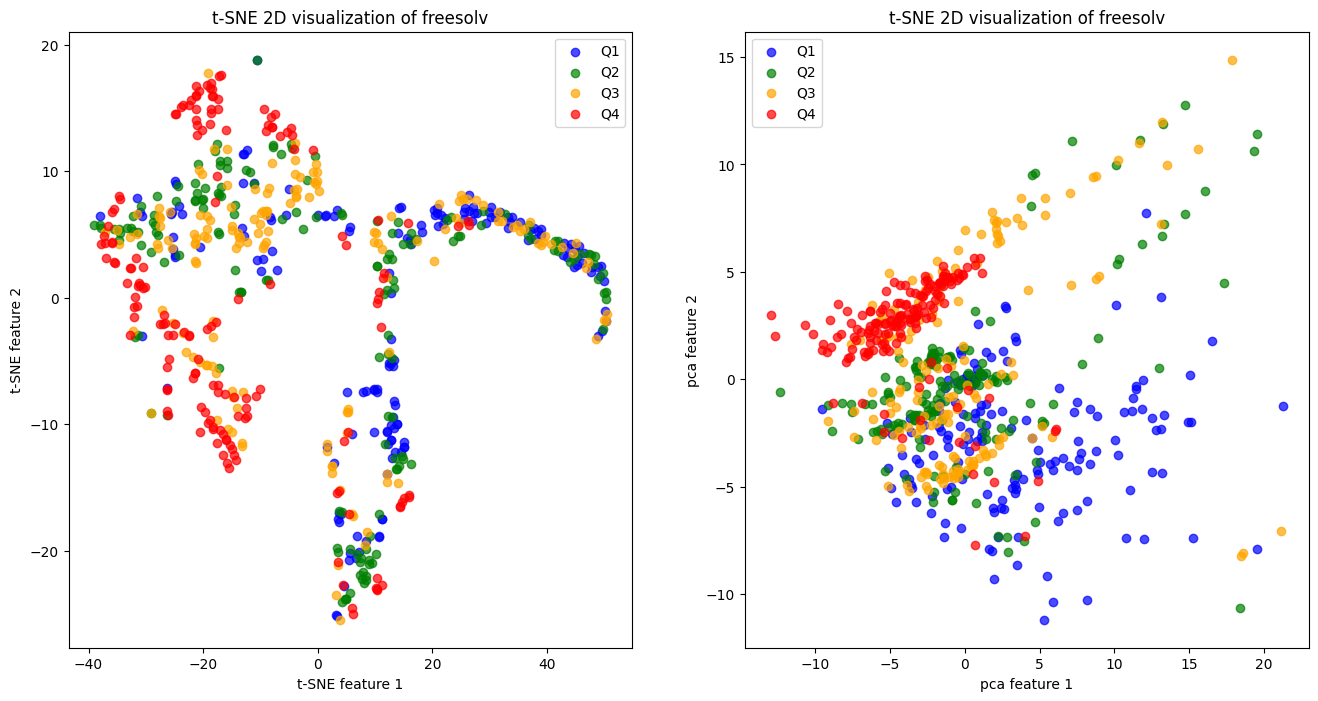

In [112]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_Q1, 0], X_tsne[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_Q2, 0], X_tsne[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_Q3, 0], X_tsne[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne[idx_Q4, 0], X_tsne[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# PCA
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_Q1, 0], X_pca2D[idx_Q1, 1], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q2, 0], X_pca2D[idx_Q2, 1], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q3, 0], X_pca2D[idx_Q3, 1], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca2D[idx_Q4, 0], X_pca2D[idx_Q4, 1], label='Q4', c='red', alpha=0.7)

ax2.set_title(f't-SNE 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

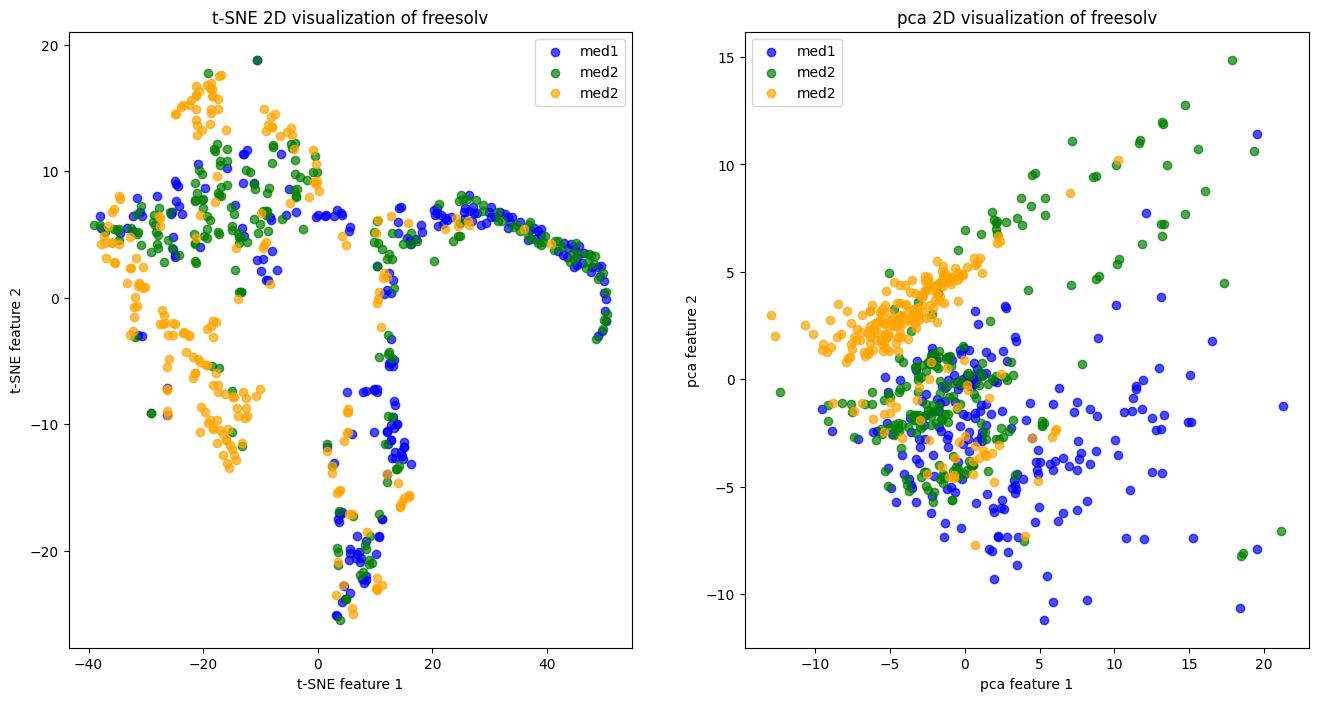

In [113]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med4, 0], X_tsne[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med5, 0], X_tsne[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne[idx_med6, 0], X_tsne[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# pca
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med4, 0], X_pca2D[idx_med4, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med5, 0], X_pca2D[idx_med5, 1], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca2D[idx_med6, 0], X_pca2D[idx_med6, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

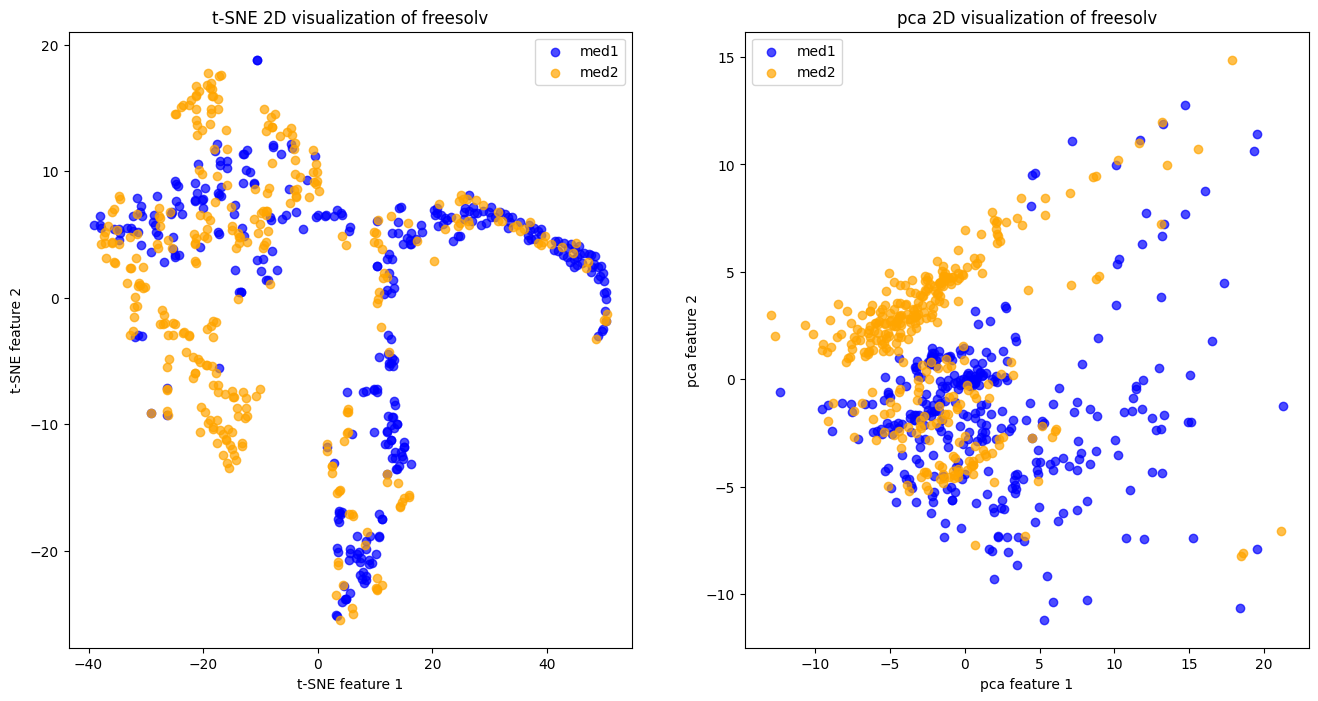

In [114]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)

ax1.scatter(X_tsne[idx_med1, 0], X_tsne[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne[idx_med2, 0], X_tsne[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 2D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.legend()

# 시각화
ax2 = fig.add_subplot(122)

ax2.scatter(X_pca2D[idx_med1, 0], X_pca2D[idx_med1, 1], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca2D[idx_med2, 0], X_pca2D[idx_med2, 1], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 2D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.legend()
plt.show()

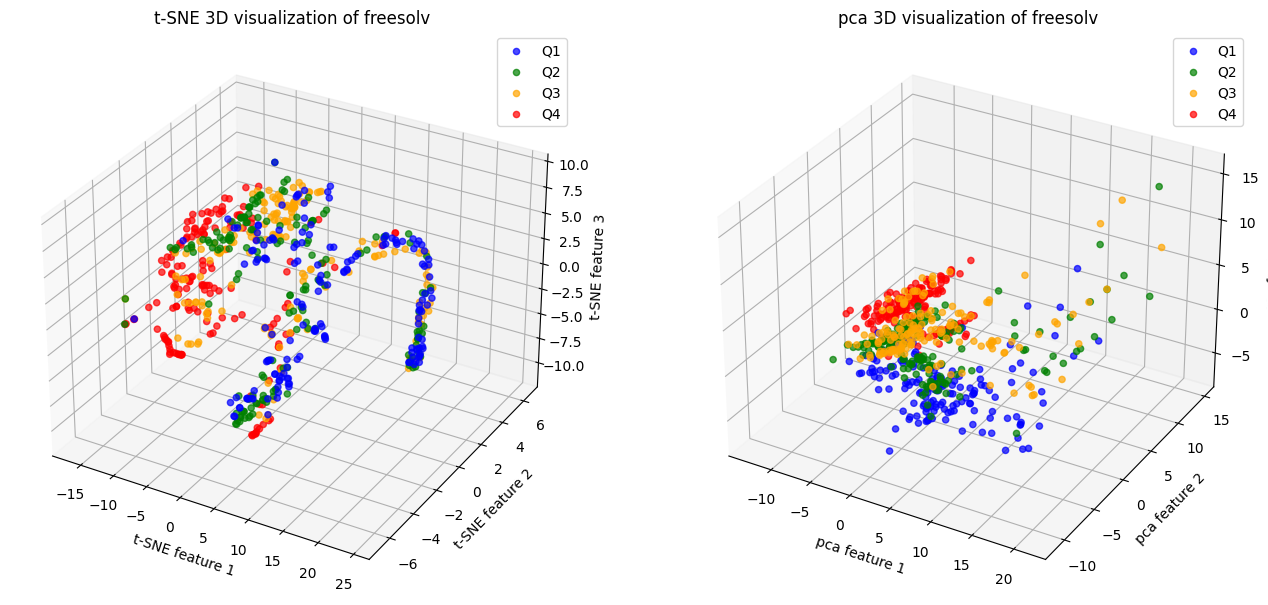

In [115]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_Q1, 0], X_tsne3D[idx_Q1, 1], X_tsne3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q2, 0], X_tsne3D[idx_Q2, 1], X_tsne3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q3, 0], X_tsne3D[idx_Q3, 1], X_tsne3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax1.scatter(X_tsne3D[idx_Q4, 0], X_tsne3D[idx_Q4, 1], X_tsne3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_Q1, 0], X_pca3D[idx_Q1, 1], X_pca3D[idx_Q1, 2], label='Q1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q2, 0], X_pca3D[idx_Q2, 1], X_pca3D[idx_Q2, 2], label='Q2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q3, 0], X_pca3D[idx_Q3, 1], X_pca3D[idx_Q3, 2], label='Q3', c='orange', alpha=0.7)
ax2.scatter(X_pca3D[idx_Q4, 0], X_pca3D[idx_Q4, 1], X_pca3D[idx_Q4, 2], label='Q4', c='red', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

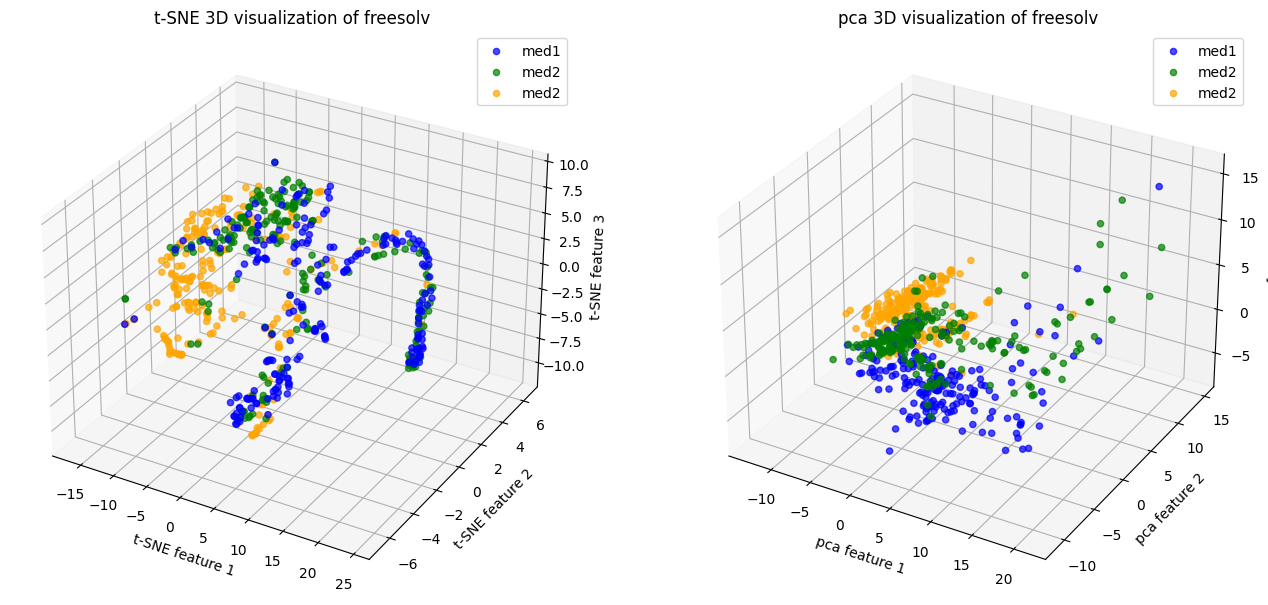

In [116]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med4, 0], X_tsne3D[idx_med4, 1], X_tsne3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med5, 0], X_tsne3D[idx_med5, 1], X_tsne3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med6, 0], X_tsne3D[idx_med6, 1], X_tsne3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med4, 0], X_pca3D[idx_med4, 1], X_pca3D[idx_med4, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med5, 0], X_pca3D[idx_med5, 1], X_pca3D[idx_med5, 2], label='med2', c='green', alpha=0.7)
ax2.scatter(X_pca3D[idx_med6, 0], X_pca3D[idx_med6, 1], X_pca3D[idx_med6, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.show()

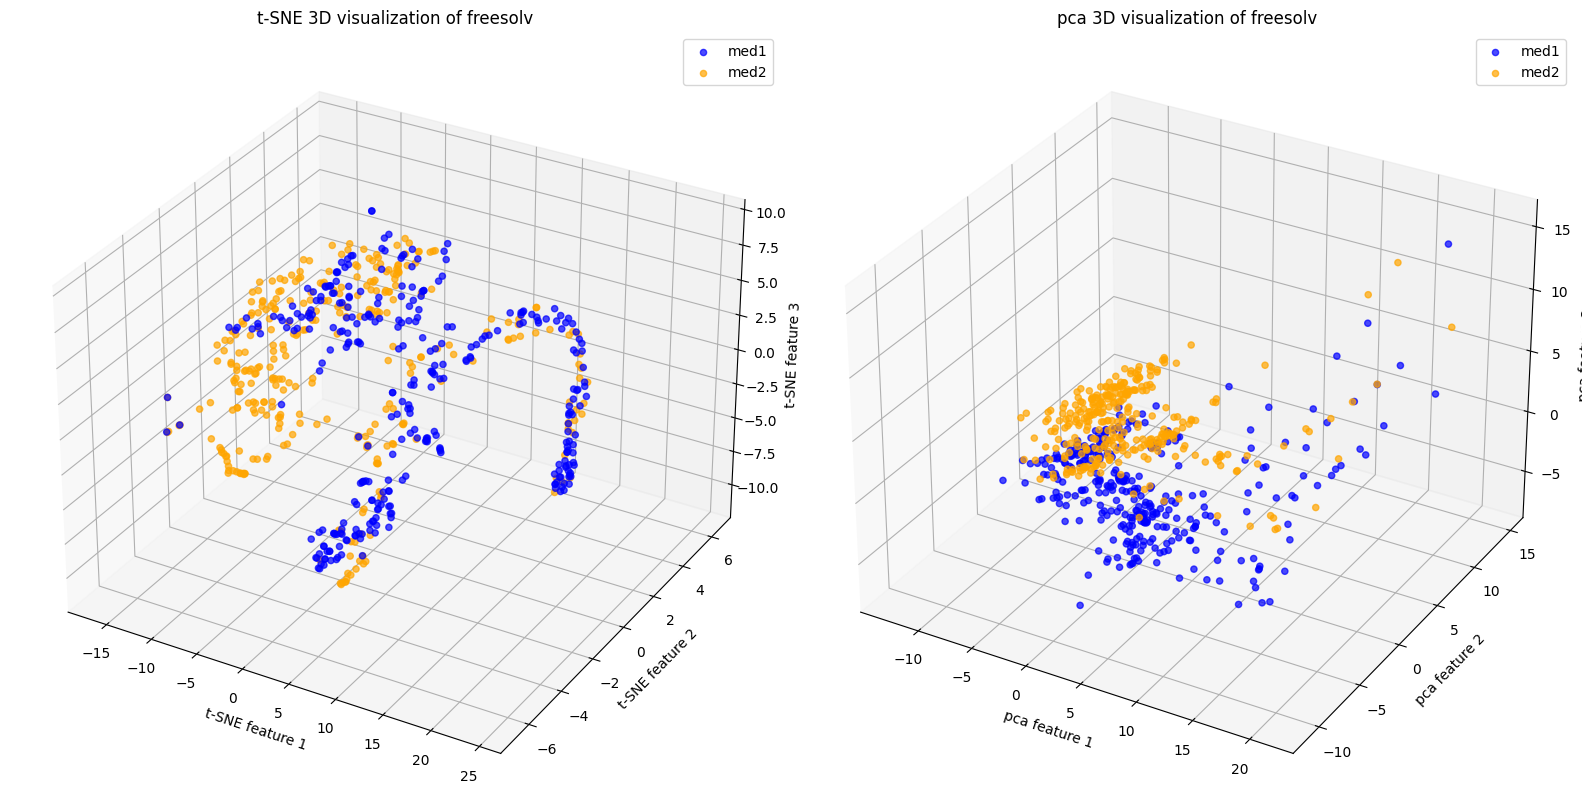

In [117]:
# t-sne
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')

ax1.scatter(X_tsne3D[idx_med1, 0], X_tsne3D[idx_med1, 1], X_tsne3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax1.scatter(X_tsne3D[idx_med2, 0], X_tsne3D[idx_med2, 1], X_tsne3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax1.set_title(f't-SNE 3D visualization of {df_name}')
ax1.set_xlabel('t-SNE feature 1')
ax1.set_ylabel('t-SNE feature 2')
ax1.set_zlabel('t-SNE feature 3')
ax1.legend()

# pca
ax2 = fig.add_subplot(122, projection='3d')

ax2.scatter(X_pca3D[idx_med1, 0], X_pca3D[idx_med1, 1], X_pca3D[idx_med1, 2], label='med1', c='blue', alpha=0.7)
ax2.scatter(X_pca3D[idx_med2, 0], X_pca3D[idx_med2, 1], X_pca3D[idx_med2, 2], label='med2', c='orange', alpha=0.7)

ax2.set_title(f'pca 3D visualization of {df_name}')
ax2.set_xlabel('pca feature 1')
ax2.set_ylabel('pca feature 2')
ax2.set_zlabel('pca feature 3')
ax2.legend()
plt.tight_layout()
plt.show()